In [1]:
import itertools
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from pathlib import Path
from cocoviz import ProblemDescription, Result, ResultSet, Indicator, rtpplot


project_dir = Path.cwd()
parent_dir = project_dir.parent
files_dir = parent_dir / "EARS comparison" / "Algorithm results" / "Runs"
print(files_dir)

DATA_DIR = Path(files_dir)

D:\Repositories\Optimization-frameworks-comparison\EARS comparison\Algorithm results\Runs


In [2]:
ALGORITHMS = ["CMA-ES-jMetal", "PSO-jMetal", "DE-jMetal", "GA-jMetal"]
FUNCTIONS = [
    "Sphere",
    "ShiftedSphere",
    "ShiftedSumOfSquares",
    "ShiftedSchwefel",
    "ShiftedRastrigin",
    "ShiftedAckley",
    "ShiftedGriewank",
    "SumOfSquares",
    "Schwefel",
    "Rastrigin",
    "Ackley",
    "Griewank",
    "Rosenbrock"
    #"ShekelsFoxholes",
    #"SixHumpCamelBack",
    #"Branin",
    #"GoldsteinPrice",
    #"Hartman"
]
VARS = [60]
RUN = [i for i in range(1, 51)]

In [ ]:
ALL_RESULTS = list(itertools.product(ALGORITHMS, FUNCTIONS, VARS, RUN))
results = ResultSet()
for alg, fn, var, run in tqdm(ALL_RESULTS):
    file_path = DATA_DIR / f"{alg}_{fn}_vars={var}_run={run}.csv"
    parquet_path = DATA_DIR / f"{alg}_{fn}_vars={var}_run={run}.parquet"
    
    # Check if file exists
    if not file_path.exists():
        print(f"Warning: CSV file not found: {file_path}")
        continue
    
    try:
        data = pd.read_csv(file_path)
        # Verify "Fitness" and "Evaluations" columns exist
        if "Fitness" not in data.columns:
            print(f"Error: 'Fitness' column missing in {file_path}")
            continue
        if "Evaluations" not in data.columns:
            print(f"Error: 'Evaluations' column missing in {file_path}")
            continue
            
        # Filter data
        data = data[data["Evaluations"] <= 10000]
        
        # Check if data is empty after filtering
        if data.empty:
            print(f"Warning: Empty data after filtering for {file_path}")
            continue
            
        # Check for NaN or invalid values in "Fitness"
        if data["Fitness"].isna().any():
            print(f"Warning: NaN values in 'Fitness' column for {file_path}")
            continue
            
        problem = ProblemDescription(fn, 1, var, 3)
        result = Result(alg, problem, data, "Evaluations")
        results.append(result)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        continue

# Check if results is empty
if not results:
    raise ValueError("No valid results were loaded. Check CSV files and data.")

In [3]:
def load_results(algorithms, functions, vars, runs, data_dir, max_evaluations=10000):
    """
    Load and validate experimental results from CSV files.

    Parameters:
    -----------
    algorithms : list
        List of algorithm names
    functions : list
        List of function names
    vars : list
        List of variable dimensions
    runs : list
        List of run numbers
    data_dir : Path
        Directory containing the data files
    max_evaluations : int, optional
        Maximum number of evaluations to include (default: 10000)

    Returns:
    --------
    ResultSet
        Collection of validated results

    Raises:
    -------
    ValueError
        If no valid results were loaded
    """
    all_results = list(itertools.product(algorithms, functions, vars, runs))
    results = ResultSet()

    for alg, fn, var, run in tqdm(all_results):
        file_path = data_dir / f"{alg}_{fn}_vars={var}_run={run}.csv"

        # Check if file exists
        if not file_path.exists():
            print(f"Warning: CSV file not found: {file_path}")
            continue

        try:
            data = pd.read_csv(file_path)
            # Verify required columns exist
            if "Fitness" not in data.columns:
                print(f"Error: 'Fitness' column missing in {file_path}")
                continue
            if "Evaluations" not in data.columns:
                print(f"Error: 'Evaluations' column missing in {file_path}")
                continue

            # Filter data
            data = data[data["Evaluations"] <= max_evaluations]

            # Check if data is empty after filtering
            if data.empty:
                print(f"Warning: Empty data after filtering for {file_path}")
                continue

            # Check for NaN or invalid values in "Fitness"
            if data["Fitness"].isna().any():
                print(f"Warning: NaN values in 'Fitness' column for {file_path}")
                continue

            problem = ProblemDescription(fn, 1, var, 3)
            result = Result(alg, problem, data, "Evaluations")
            results.append(result)
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            continue

    # Check if results is empty
    if not results:
        raise ValueError("No valid results were loaded. Check CSV files and data.")

    return results

  0%|          | 0/2600 [00:00<?, ?it/s]

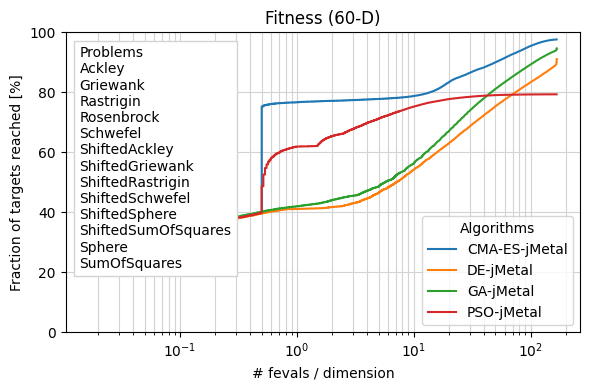

In [4]:
from cocoviz.indicator import register

results = load_results(
    algorithms=ALGORITHMS,
    functions=FUNCTIONS,
    vars=VARS,
    runs=RUN,
    data_dir=DATA_DIR
)


number_of_targets = 1001

INDICATOR = Indicator("Fitness", display_name="Fitness", larger_is_better=False)
#register(INDICATOR)

nvar = len(results.number_of_variables)
fig, axes = plt.subplots(nvar, 1, figsize=(6, 4), squeeze=False)

for axrow, (d, result_subset) in zip(axes, results.by_number_of_variables()):
    ax = axrow[0]  # Single axis since only one column
    rtpplot(result_subset, INDICATOR, number_of_targets=number_of_targets, ax=ax)
    ax.set_title(f"{INDICATOR.display_name} ({d}-D)")

plt.tight_layout()
#plt.savefig("profiles-aggregated.pdf", bbox_inches="tight")

In [ ]:
fig, axes = plt.subplots(len(FUNCTIONS), len(VARS), figsize=(10, 12))
for ax, (r, result_subset) in zip(axes.flatten(), results.by_problem()):
    rtpplot(result_subset, INDICATOR, number_of_targets=number_of_targets, ax=ax)
    ax.set_title(f"Fitness ({r.name}, {r.number_of_variables}-D)")
plt.tight_layout()

In [ ]:
# Create subplots with len(FUNCTIONS) rows and 1 column
n_functions = len(FUNCTIONS)
fig, axes = plt.subplots(n_functions, 1, figsize=(6, n_functions * 3), constrained_layout=True)

# Loop over results by problem
for ax, (r, result_subset) in zip(axes, results.by_problem()):
    rtpplot(result_subset, INDICATOR, number_of_targets=number_of_targets, ax=ax)
    ax.set_title(f"Fitness ({r.name}, {r.number_of_variables}-D)")

plt.show()

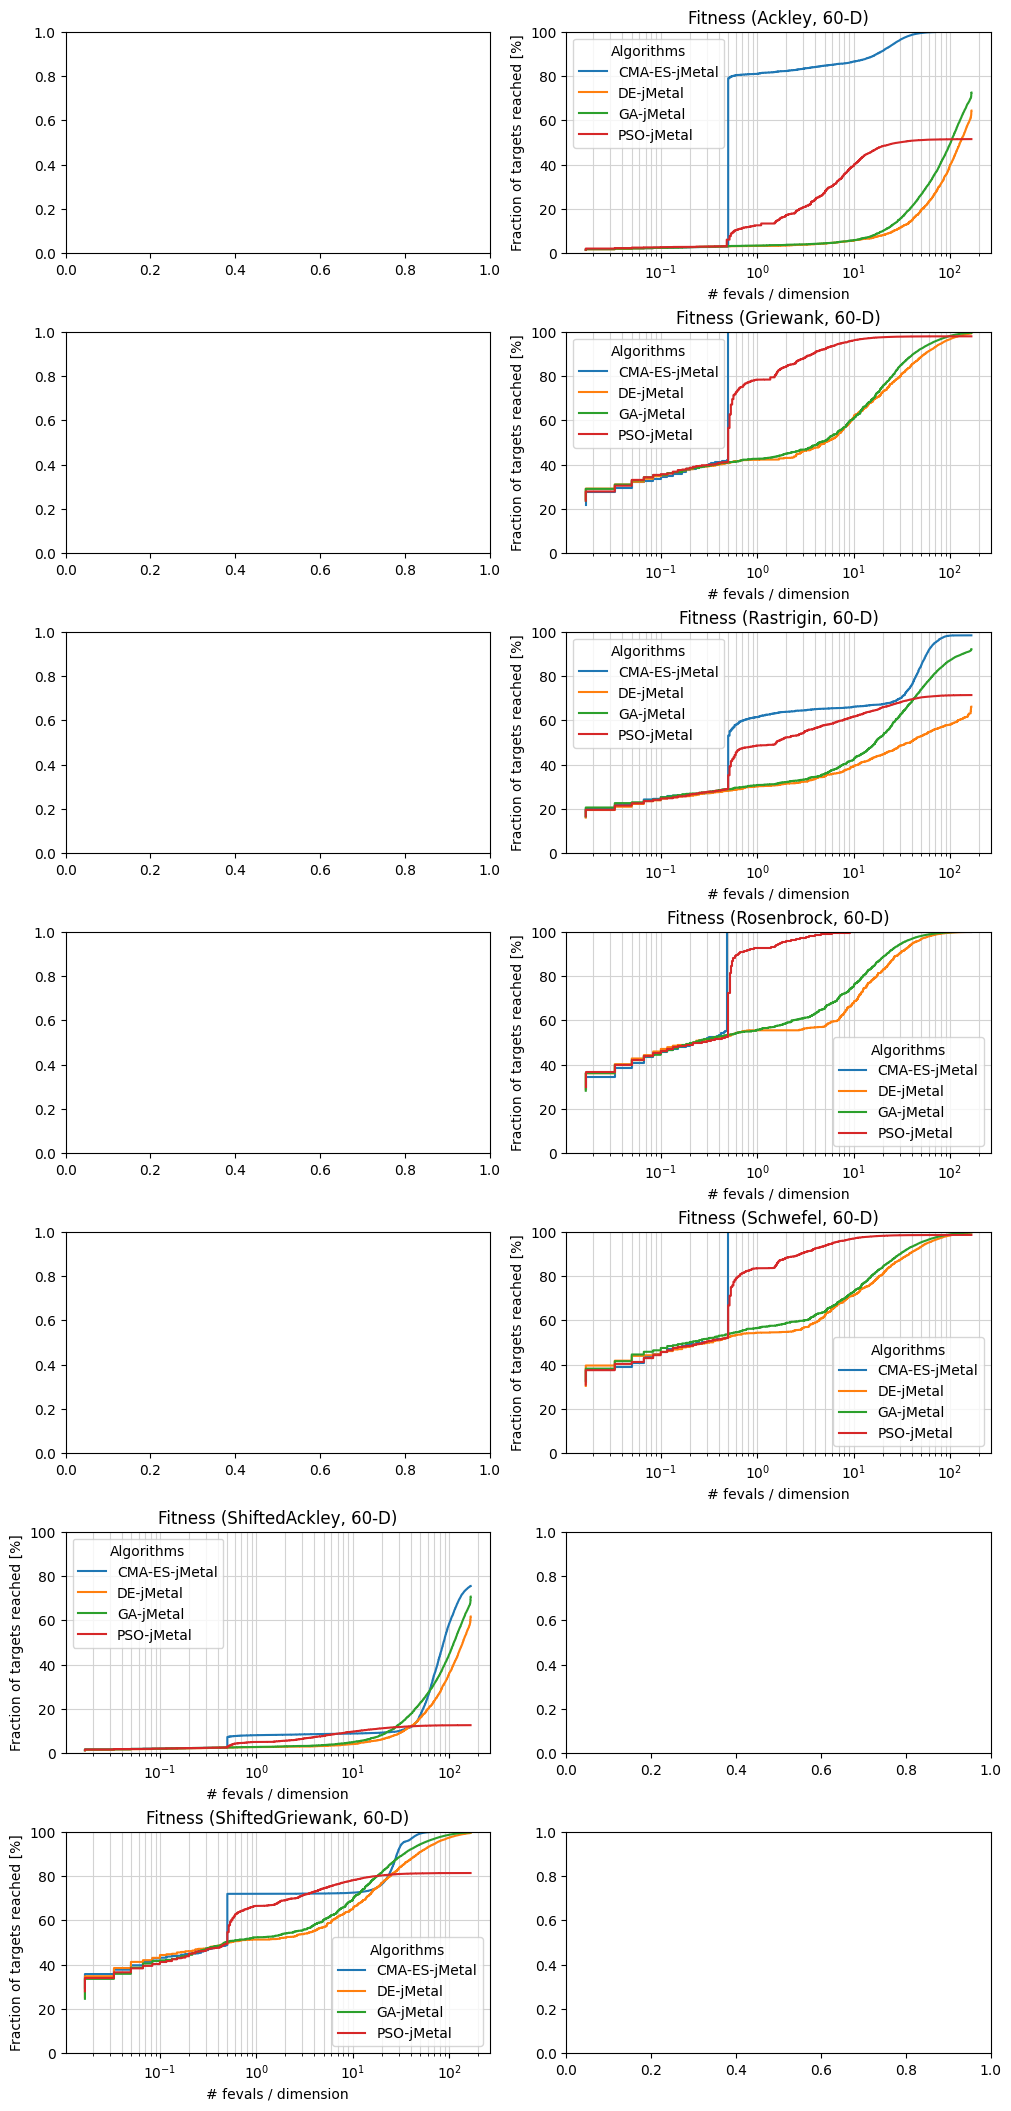

In [17]:
# Split FUNCTIONS into two groups for two columns
n_functions = len(FUNCTIONS)
mid = (n_functions + 1) // 2  # Ceiling division for uneven split
col1_functions = FUNCTIONS[:mid]  # First 7 functions
col2_functions = FUNCTIONS[mid:]  # Last 6 functions
n_rows = mid  # 7 rows to fit all functions

# Create subplots with n_rows (7) and 2 columns
fig, axes = plt.subplots(n_rows, 2, figsize=(10, n_rows * 3), constrained_layout=True)

# Plot first column
for i, (ax, (r, result_subset)) in enumerate(zip(axes[:, 0], results.by_problem())):
    if r.name in col1_functions:
        rtpplot(result_subset, INDICATOR, number_of_targets=number_of_targets, ax=ax)
        ax.set_title(f"Fitness ({r.name}, {r.number_of_variables}-D)")

# Plot second column
for i, (ax, (r, result_subset)) in enumerate(zip(axes[:len(col2_functions), 1], results.by_problem())):
    if r.name in col2_functions:
        rtpplot(result_subset, INDICATOR, number_of_targets=number_of_targets, ax=ax)
        ax.set_title(f"Fitness ({r.name}, {r.number_of_variables}-D)")

plt.show()